In [354]:
import pandas as pd
import numpy as np
#tf.compat.v1.disable_v2_behavior()
from math import sqrt, floor
from matplotlib import pyplot

## Load Data

In [355]:
df_tweets = pd.read_csv("musk_2021.csv", parse_dates = ['date'], index_col=0)
df_tweets.set_index("date", inplace=True)
df_tweets.sort_index(ascending=True, inplace=True)
print(df_tweets.shape)
df_tweets.head(1)

(12339, 37)


,id,conversation_id,created_at,timezone,place,tweet,language,hashtags,cashtags,user_id,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
date,,,,,,,,,,,,,,,,,,,,,
2010-06-04 18:31:57,15434727182,15434727182,1.275676e+12,0,NaN,"Please ignore prior tweets, as that was someon...",en,[],[],44196397,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [356]:
df_trump = pd.read_csv("trump_tweets.csv", parse_dates = ['date'], index_col=7)
print(df_trump.shape)
df_trump.head(1)

(56571, 8)


,id,text,isRetweet,isDeleted,device,favorites,retweets,isFlagged
date,,,,,,,,
2009-05-04 18:54:00,1.698309e+09,Be sure to tune in and watch Donald Trump on L...,f,f,Twitter Web Client,939,519,f


In [357]:
df_doge = pd.read_csv("Daily-DOGE-USD.csv", parse_dates=['Date'], index_col=0)
print(df_doge.shape)
df_doge.head(3)

(1462, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-24,0.001731,0.001845,0.001722,0.001816,0.001816,4796720.0
2017-08-25,0.001808,0.001830,0.001762,0.001790,0.001790,2654040.0
2017-08-26,0.001787,0.001797,0.001735,0.001778,0.001778,1935350.0


# LSTM Application

## Function For Converting Time Series Data For Supervised Learning

In [358]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Preparing Data

In [359]:
# Aligning Tweet Data with Doge Data
df_tweets = df_tweets.loc[(df_tweets.index >= '2017-08-24')]
df_tweets = df_tweets.loc[(df_tweets.index <= '2021-01-08')]
# Dropping columns that are unexpected to be useful
df_tweets = df_tweets.drop(columns=[
    'id', 'conversation_id', 'timezone', 'place',
    'language', 'user_id', 'geo', 'source', 'user_rt_id',
    'user_rt', 'retweet_id', 'reply_to', 'retweet_date',
    'translate', 'trans_src', 'trans_dest', 'user_id_str',
    'username', 'name', 'day', 'hour', 'link', 'urls',
    'photos', 'video', 'thumbnail', 'retweet', 'quote_url',
    'search', 'near', 'created_at', 'tweet', 'hashtags',
    'cashtags'
], axis=1)

# Changing by the second data to by the day data
changed1 = df_tweets.groupby([df_tweets.index.date]).size().reset_index(name='Musk Tweet Count')
changed2 = df_tweets.groupby([df_tweets.index.date]).agg('sum')
changed1 = changed1.set_index('index')

df_tweets = changed1.merge(changed2, how='outer', left_index=True, right_index=True)
df_tweets = df_tweets.rename_axis('Date')
df_tweets.rename(columns={"nlikes": "Musk Likes", "nreplies": "Musk Replies", "nretweets": "Musk Retweets"}, inplace=True)
print(df_tweets.shape)
df_tweets.head(1)

(1058, 4)


,Musk Tweet Count,Musk Likes,Musk Replies,Musk Retweets
Date,,,,
2017-08-25,12,59024,1790,6875


In [360]:
# Aligning Tweet Data with Doge Data
df_trump = df_trump.loc[(df_trump.index >= '2017-08-24')]
# Dropping ID column since it's unexpected to be useful
df_trump = df_trump.drop(columns=['id'], axis=1)

# Changing by the second data to by the day data
changed1 = df_trump.groupby([df_trump.index.date]).size().reset_index(name='Trump Tweet Count')
changed2 = df_trump.groupby([df_trump.index.date]).agg('sum')
changed1 = changed1.set_index('index')

df_trump = changed1.merge(changed2, how='outer', left_index=True, right_index=True)
df_trump = df_trump.rename_axis('Date')
df_trump.rename(columns={"favorites": "Trump Favorites", "retweets": "Trump Retweets"}, inplace=True)
print(df_trump.shape)
df_trump.head(1)

(1227, 3)


,Trump Tweet Count,Trump Favorites,Trump Retweets
Date,,,
2017-08-24,15,553551,146247


(1234, 6)


Text(0.5, 1.0, 'DogeCoin Daily Volume')

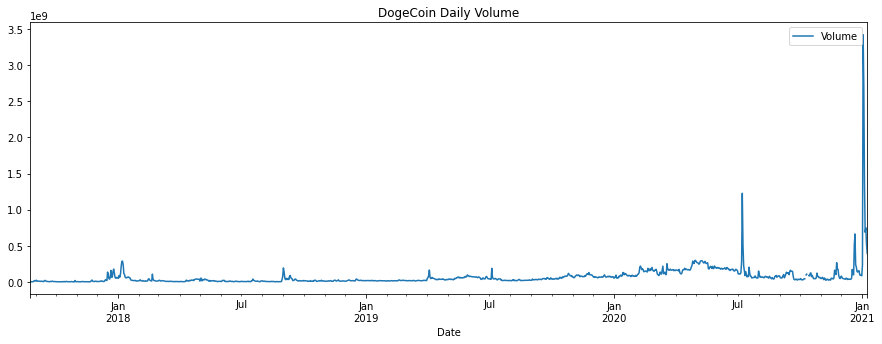

In [361]:
# Aligning Doge Data with Tweet Data
df_doge = df_doge.loc[(df_doge.index <= '2021-01-08')]
#df_doge = df_doge.drop(columns=['Open', 'High', 'Low', 'Close'], axis=1)
print(df_doge.shape)
df_doge.plot(y='Volume', figsize=(15,5)).set_title('DogeCoin Daily Volume')

### Converting Data for Supervised Learning

In [362]:
# Merging Two Data Sets Together
df = df_doge.merge(df_tweets, how='outer', left_index=True, right_index=True)
df = df.merge(df_trump, how='outer', left_index=True, right_index=True)
df.fillna(0, inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Musk Tweet Count,Musk Likes,Musk Replies,Musk Retweets,Trump Tweet Count,Trump Favorites,Trump Retweets
Date,,,,,,,,,,,,,
2017-08-24,0.001731,0.001845,0.001722,0.001816,0.001816,4796720.0,0.0,0.0,0.0,0.0,15.0,553551.0,146247.0
2017-08-25,0.001808,0.001830,0.001762,0.001790,0.001790,2654040.0,12.0,59024.0,1790.0,6875.0,14.0,676700.0,148426.0
2017-08-26,0.001787,0.001797,0.001735,0.001778,0.001778,1935350.0,2.0,2092.0,96.0,127.0,12.0,577719.0,130227.0
2017-08-27,0.001779,0.001784,0.001745,0.001760,0.001760,2241620.0,11.0,33508.0,1190.0,6658.0,11.0,733628.0,144351.0
2017-08-28,0.001764,0.001825,0.001751,0.001825,0.001825,3210440.0,18.0,211029.0,6746.0,52456.0,4.0,0.0,68447.0


In [363]:
from sklearn.preprocessing import MinMaxScaler

values = df.values
# integer encoding of labels (not using yet here)
#encoder = LabelEncoder()
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# Drop Columns of Variables We Aren't Predicting
reframed.drop(reframed.columns[[13,14,15,16,17,19,20,21,22,23,24,25]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[9,11,12,13,14,15,16,17]], axis=1, inplace=True)
print(reframed.shape)
reframed.head()


(1233, 14)


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var6(t)
1,0.101139,0.098279,0.118131,0.106273,0.106273,0.001402,0.000000,0.000000,0.000000,0.000000,0.098039,0.067624,0.058361,0.000776
2,0.105638,0.097480,0.120875,0.104752,0.104752,0.000776,0.214286,0.025345,0.019659,0.018324,0.091503,0.082669,0.059230,0.000566
3,0.104411,0.095723,0.119023,0.104050,0.104050,0.000566,0.035714,0.000898,0.001054,0.000339,0.078431,0.070577,0.051968,0.000655
4,0.103944,0.095030,0.119709,0.102996,0.102996,0.000655,0.196429,0.014389,0.013069,0.017746,0.071895,0.089623,0.057604,0.000938
5,0.103067,0.097214,0.120121,0.106800,0.106800,0.000938,0.321429,0.090617,0.074088,0.139814,0.026144,0.000000,0.027314,0.002011


## Running Model

In [364]:
# split into train, test, and prediction sets
values = reframed.values
#n_predict = floor((len(values) * 0.10))
n_predict = floor(365/4)
n_train = floor((len(values) * 0.80))
train = values[:n_train, :]
test = values[n_train:len(values)-n_predict, :]
predict = values[len(values)-n_predict:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
predict_X, predict_y = predict[:, :-1], predict[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
predict_X = predict_X.reshape((predict_X.shape[0], 1, predict_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, predict_X.shape, predict_y.shape)

(986, 1, 13) (986,) (156, 1, 13) (156,) (91, 1, 13) (91,)


In [365]:
# design network
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, Activation
from tensorflow.keras.metrics import RootMeanSquaredError

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=0.5, return_sequences=True))
model.add(LSTM(100, dropout=0.5, return_sequences=False))
model.add(Dense(1, activation='linear'))

model.compile(
    loss='mae',
    optimizer='rmsprop',
    metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 1, 50)             12800     
_________________________________________________________________
lstm_51 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 101       
Total params: 73,301
Trainable params: 73,301
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
14/14 - 3s - loss: 0.0092 - root_mean_squared_error: 0.0131 - val_loss: 0.0228 - val_root_mean_squared_error: 0.0358
Epoch 2/100
14/14 - 0s - loss: 0.0122 - root_mean_squared_error: 0.0166 - val_loss: 0.0217 - val_root_mean_squared_error: 0.0353
Epoch 3/100
14/14 - 0s - loss: 0.0110 - root_mean_squared_error: 0.0153 - val_loss: 0.0218 - val_root_mean_squared_error: 0.0352
Epoch 4/100
14/14 - 0s - loss: 0.0112 - root_mean_squared_error: 0.0153 - val_loss: 0.0215 - val_root_mean_squared_error: 0.0353
Epoch 5/100
14/14 - 0s - loss: 0.0113 - root_mean_squared_error: 0.0155 - val_loss: 0.0214 - val_root_mean_squared_error: 0.0352
Epoch 6/100
14/14 - 0s - loss: 0.0112 - root_mean_squared_error: 0.0154 - val_loss: 0.0213 - val_root_mean_squared_error: 0.0352
Epoch 7/100
14/14 - 0s - loss: 0.0109 - root_mean_squared_error: 0.0152 - val_loss: 0.0212 - val_root_mean_squared_error: 0.0352
Epoch 8/100
14/14 - 0s - loss: 0.0108 - root_mean_squared_error: 0.0148 - val_loss: 0.0212 - val_

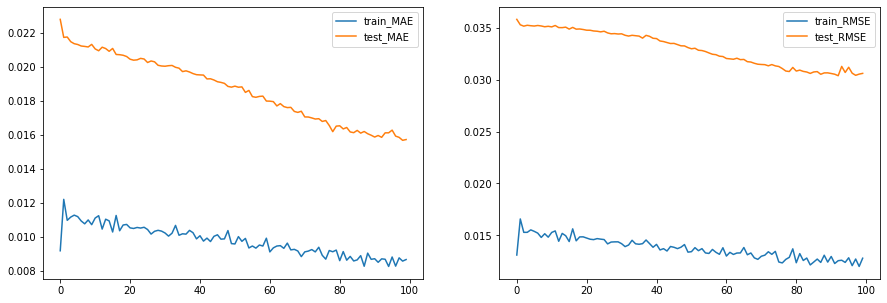

In [366]:
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.figure(figsize=(15,5))
pyplot.subplot(1, 2, 1)
pyplot.plot(history.history['loss'], label='train_MAE')
pyplot.plot(history.history['val_loss'], label='test_MAE')
pyplot.legend()
pyplot.subplot(1, 2, 2)
pyplot.plot(history.history['root_mean_squared_error'], label='train_RMSE')
pyplot.plot(history.history['val_root_mean_squared_error'], label='test_RMSE')
pyplot.legend()
pyplot.show()

## Analysis

In [367]:
# make a prediction
yhat = model.predict(predict_X)
predict_X_2D = predict_X.reshape((predict_X.shape[0], predict_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, predict_X_2D[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
predict_y = predict_y.reshape((len(predict_y), 1))
inv_y = np.concatenate((predict_y, predict_X_2D[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [368]:
from sklearn.metrics import mean_squared_error

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
normalized_rmse = rmse/(max(max(inv_yhat),max(inv_y))-min(min(inv_yhat),min(inv_y)))
print('Normalized RMSE: %.3f' % normalized_rmse)

Test RMSE: 0.002
Normalized RMSE: 0.107


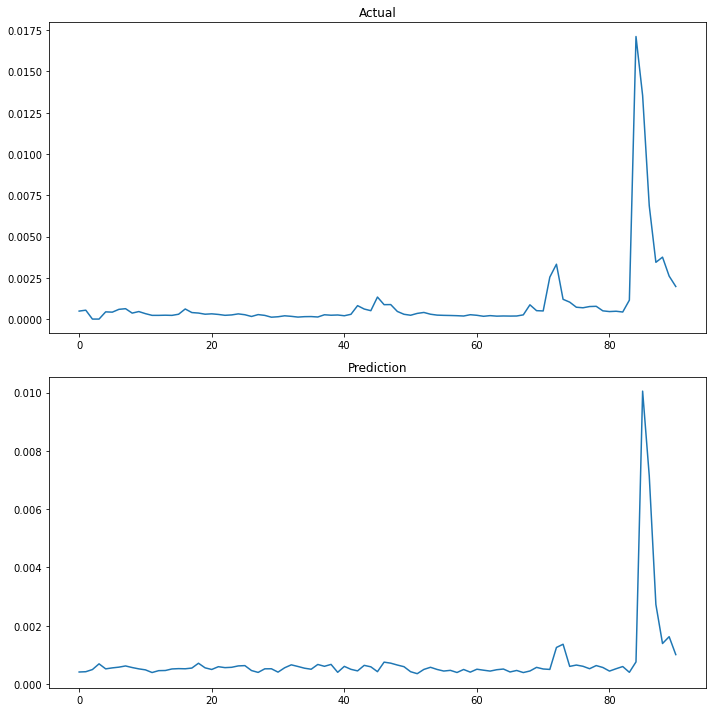

In [369]:
# Plot of Prediction vs Actual
pyplot.figure(figsize=(10,10))
pyplot.subplot(2, 1, 1)
pyplot.plot(inv_y, label="Actual")
pyplot.title("Actual")
pyplot.subplot(2, 1, 2)
pyplot.plot(inv_yhat, label="Prediction")
pyplot.title("Prediction")
pyplot.tight_layout()
pyplot.show()

In [370]:
import shap

# Create explainer for SHAP feature analysis
explainer = shap.GradientExplainer(model, train_X)
shap_values = explainer.shap_values(predict_X)
shap.initjs()

# Data has to be converted to 2D
shap_values_2D = shap_values[0].reshape(-1,13)


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


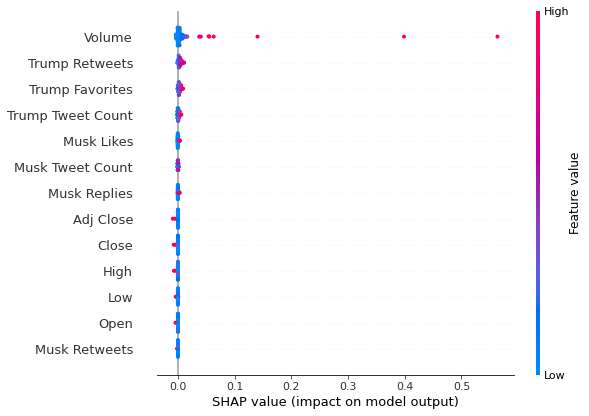

In [371]:
# Plot of Feature Importance
shap.summary_plot(shap_values_2D, features=predict_X_2D, feature_names=df.columns)